In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import jax
import jax.numpy as jnp
import os
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pickle
from tqdm.auto import tqdm
from ipywidgets import *

from shortfall.consts import *
from shortfall.strategy import *
import shortfall.gradient.base_cost_models as bcm
import shortfall.gradient.optimize_repay_ratchet as orr

In [3]:
initial_pledge_projection_period_days = 20
supply_lock_target = 0.3

# define various loss functions to explore
sampling_rate = 30  # sampling rate of the income curve
strategy_str = 'power_limited' # can be pledge_limited or power_limited

pledge_limited_base = StrategyConfig.pledge_limited(1000.0, 3 * YEAR, False)
pledge_limited_shortfall = StrategyConfig.pledge_limited(1000.0, 3 * YEAR, True)
power_limited_base = StrategyConfig.power_limited(100 * TIBIBYTE / EXBIBYTE, 3 * YEAR, False)
power_limited_shortfall = StrategyConfig.power_limited(100 * TIBIBYTE / EXBIBYTE, 3 * YEAR, True)

def get_base_income(x):
    pledge_limited_base_stats = bcm.compute_baseline(initial_pledge_projection_period_days, supply_lock_target,
                                      strategy=pledge_limited_base)
    pledge_limited_income_base = bcm.compute_income_borrow_apy(pledge_limited_base_stats, borrow_amt=bcm.BORROW_AMT, apy=bcm.APY, sampling_rate_days=bcm.SAMPLING_RATE_DAYS)
    power_limited_base_stats = bcm.compute_baseline(initial_pledge_projection_period_days, supply_lock_target,
                                      strategy=power_limited_base)
    power_limited_income_base = bcm.compute_income_borrow_apy(power_limited_base_stats, borrow_amt=bcm.BORROW_AMT, apy=bcm.APY, sampling_rate_days=bcm.SAMPLING_RATE_DAYS)
    
    return pledge_limited_income_base, power_limited_income_base
    
def get_repay_income(x):    
    pledge_limited_repay_stats = orr.compute_repay_ratchet(x, strategy=pledge_limited_shortfall)
    indices = np.arange(sampling_rate, len(pledge_limited_repay_stats), sampling_rate)
    pledge_limited_income_shortfall = jnp.asarray([pledge_limited_repay_stats[ii]['net_equity'] for ii in indices])
    
    power_limited_repay_stats = orr.compute_repay_ratchet(x, strategy=power_limited_shortfall)
    indices = np.arange(sampling_rate, len(power_limited_repay_stats), sampling_rate)
    power_limited_income_shortfall = jnp.asarray([power_limited_repay_stats[ii]['net_equity'] for ii in indices])
    
    return pledge_limited_income_shortfall, power_limited_income_shortfall


x_noop = []
base_income_per_pledge, base_income_per_QAP = get_base_income(x_noop)

def loss_fn(x, w):
    repay_income_per_pledge, repay_income_per_QAP = get_repay_income(x)
    
    w1 = w
    w2 = 1. - w1
    
    # V3
    O1 = np.linalg.norm(base_income_per_QAP - 0.8*repay_income_per_QAP) # in power-limited case, we want shortfall to be 10% less effective
    O2 = np.linalg.norm(repay_income_per_pledge - 0.8*base_income_per_pledge) # in pledge-limited case, we want shortfall to be profitable    
    loss = w1 * O1 + w2 * O2

    return loss

In [4]:
w_vec = np.linspace(0,1,11)

results_dict = {}

for w in tqdm(w_vec):

    max_fee_reward_fraction_vec = np.linspace(0.1, 0.9, 10)  # y
    token_lease_fee_vec = np.linspace(0.1, 0.9, 8)  # x

    loss_surface = np.zeros((len(max_fee_reward_fraction_vec), len(token_lease_fee_vec)))
    for ii in range(len(max_fee_reward_fraction_vec)):
        for jj in range(len(token_lease_fee_vec)):
            x = jnp.asarray([max_fee_reward_fraction_vec[ii], token_lease_fee_vec[jj]])
            loss_surface[ii,jj] = loss_fn(x, w)
            
    min_ii, min_jj = np.unravel_index(loss_surface.argmin(), loss_surface.shape)
    best_max_fee_reward_fraction = max_fee_reward_fraction_vec[min_ii]
    best_token_lease_fee = token_lease_fee_vec[min_jj]
    best_repay_income_per_pledge, best_repay_income_per_QAP = get_repay_income(jnp.asarray([best_max_fee_reward_fraction, best_token_lease_fee]))
    
    out_dict = {
        'loss_surface': loss_surface,
        'best_repay_income_per_pledge': best_repay_income_per_pledge,
        'best_repay_income_per_QAP': best_repay_income_per_QAP,
        'min_ii': min_ii,
        'min_jj': min_jj,
    }
    results_dict[w] = out_dict

  0%|          | 0/11 [00:00<?, ?it/s]

In [5]:
with open('optimize_repay.pkl', 'wb') as f:
    pickle.dump(results_dict, f)

In [14]:
with open('optimize_repay.pkl', 'rb') as f:
    results_dict = pickle.load(f)

In [7]:
alex_repay_income_per_pledge, alex_repay_income_per_QAP = get_repay_income(jnp.asarray([0.25, 0.3]))

In [8]:
def find_closest_idx(a, a0):
    idx = np.abs(a - a0).argmin()
    return a.flat[idx]

<IPython.core.display.Javascript object>


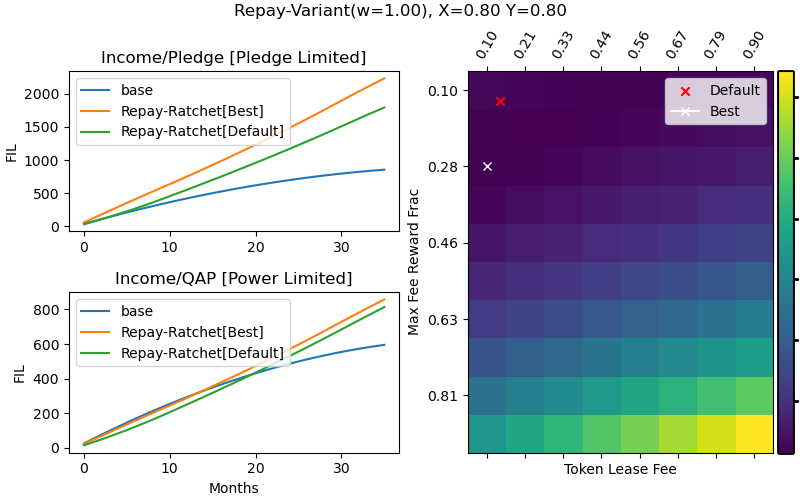

interactive(children=(FloatSlider(value=0.5, description='w', max=1.0), Output()), _dom_classes=('widget-inter…

<function __main__.update(w=0.5)>

In [17]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, axd = plt.subplot_mosaic([['upper left', 'right'],
                               ['lower left', 'right']],
                              figsize=(8, 5), layout="constrained")

ax = axd['upper left']
ax.plot(base_income_per_pledge, label='base')
repay_pledge_limited, = ax.plot(best_repay_income_per_pledge, label='Repay-Ratchet[Best]')
ax.plot(alex_repay_income_per_pledge, label='Repay-Ratchet[Default]')
ax.set_title('Income/Pledge [Pledge Limited]')
ax.legend()
ax.set_ylabel('FIL')

ax = axd['lower left']
ax.plot(base_income_per_QAP, label='base')
repay_power_limited, = ax.plot(best_repay_income_per_QAP, label='Repay-Ratchet[Best]')
ax.plot(alex_repay_income_per_QAP, label='Repay-Ratchet[Default]')
ax.set_title('Income/QAP [Power Limited]')
ax.legend()
ax.set_xlabel('Months')
ax.set_ylabel('FIL')

xt = ['%0.02f' % (x,) for x in token_lease_fee_vec]
yt = ['%0.02f' % (x,) for x in max_fee_reward_fraction_vec]
ax3 = axd['right']
z = ax3.matshow(loss_surface)
ax3.scatter([find_closest_idx(token_lease_fee_vec, 0.3)], 
           [find_closest_idx(max_fee_reward_fraction_vec, 0.25)], color='red', marker='x', label='Default')
best_point, = ax3.plot([min_jj], [min_ii], color='white', marker='x', label='Best')
ax3.set_xticks(range(len(xt)))
ax3.set_yticks(range(len(yt)))
ax3.set_xticklabels(xt, rotation=60)
ax3.set_yticklabels(yt)
ax3.set_xlabel('Token Lease Fee')
ax3.set_ylabel('Max Fee Reward Frac')
ax3.legend()

divider = make_axes_locatable(ax3)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(z, cax=cax, orientation='vertical')

plt.suptitle('Repay-Ratchet Variant X=%0.02f Y=%0.02f' % (0.8, 0.8))

def get_closest_key(key_in):
    keys = np.asarray(list(results_dict.keys()))
    ii = np.argmin(np.abs(keys-key_in))
    return keys[ii]

def update(w=0.5):
    w_in = get_closest_key(w)
    res_dict = results_dict[w_in]
    loss_surface = res_dict['loss_surface']
    best_burn_income_per_pledge = res_dict['best_repay_income_per_pledge']
    best_burn_income_per_QAP = res_dict['best_repay_income_per_QAP']
    min_ii = res_dict['min_ii'] 
    min_jj = res_dict['min_jj']
    
    best_point.set_data([min_jj], [min_ii])
    
    repay_pledge_limited.set_ydata(best_burn_income_per_pledge)
    repay_power_limited.set_ydata(best_burn_income_per_QAP)
    ax3.matshow(loss_surface)
    
    divider = make_axes_locatable(ax3)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(z, cax=cax, orientation='vertical')

    plt.suptitle('Repay-Variant(w=%0.02f), X=%0.02f Y=%0.02f' % (w, 0.8, 0.8))
    fig.canvas.draw_idle()


interact(update, w=(0,1,0.1))
